## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [115]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/"
csv_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/"
gtf_name = "Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf"
mutation = 'efp'
samp_num = '1'

## Loading up the data files 

In [116]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [117]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [118]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [119]:
data = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)

## Getting the codon sequence:

If get.sequence returns the entire sequence, then it should be fairly simple to just index it with the numbers returned by get_cds stop and end so that I only have to look at the coding regions... Now how am I going to read through this such that each codon gets its own little name? 

Perhaps I should consider trying to run biopython in such a way that I do not have to save it into it's own dictionary like this.

In [120]:
genome = SeqIO.to_dict(SeqIO.parse(
    open(data_path + "Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.cdna.all.fa"),"fasta"))
# Using this cds file leads to everything being in 

In [121]:
cds_sequence=[]

for transcript in protein_coding:
    t_id = transcript.attr["transcript_id"]
    cds_sequence.append(str(genome[t_id].seq))

In [122]:
cd_dict = {'TTT':0,'TTC':1,'TTG':2,'TTA':3,
          'TCT':4,'TCC':5,'TCG':6,'TCA':7,
          'TGT':8,'TGC':9,'TGG':10,'TGA':11,
          'TAT':12,'TAC':13,'TAG':14,'TAA':15,
          'CTT':16,'CTC':17,'CTG':18,'CTA':19,
          'CCT':20,'CCC':21,'CCG':22,'CCA':23,
          'CGT':24,'CGC':25,'CGG':26,'CGA':27,
          'CAT':28,'CAC':29,'CAG':30,'CAA':31,
          'GTT':32,'GTC':33,'GTG':34,'GTA':35,
          'GCT':36,'GCC':37,'GCG':38,'GCA':39,
          'GGT':40,'GGC':41,'GGG':42,'GGA':43,
          'GAT':44,'GAC':45,'GAG':46,'GAA':47,
          'ATT':48,'ATC':49,'ATG':50,'ATA':51,
          'ACT':52,'ACC':53,'ACG':54,'ACA':55,
          'AGT':56,'AGC':57,'AGG':58,'AGA':59,
          'AAT':60,'AAC':61,'AAG':62,'AAA':63}

In [123]:
codon_seq_list = []

for seq in cds_sequence:
    codon_seq = []
    for i in range(0, len(seq), 3):
        try:
            codon_seq.append(cd_dict[seq[i:i+3]])
        except:
            pass
    codon_seq_list.append(codon_seq)

ok... I think i need to use the except pass thing because some of the coding sequences is not quite a multiple of three. I need to change that try, except, pass so that it gives me information on the gene in questions whenever it comes up. 

## Calculating Elongation rates

In [124]:
len(protein_coding)

4239

In [125]:
# Choosing a gene of interest to calculate the elongation rates of. 
#Get the transcript and vector for the gene of interest
my_gene = "mltG"
my_transcript, my_vector, index = kat.find_transcript(my_gene, 
                                           protein_coding, data)

In [126]:
# Add one to every point in my vector to create a new baseline
my_vector = my_vector+1

In [127]:
# calculate the normalized profile (p) of my vector of interest

M = sum(my_vector)
p = my_vector/M

In [128]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
x=0
pbar=[]
for px in p:
    pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
    pbar.append(pbar_x)
    x = x+1
    if x  == len(p)-9:
        break
pbar = np.array(pbar)

In [129]:
# calculate the smoothed, scaled elongation rate lambda bar 
lbar = []
for pbarx in pbar:
    lbar_x = (1-9*pbarx)/(pbarx*(1-pbarx))
    lbar.append(lbar_x)
lbar = np.array(lbar)

In [130]:
# Calculate the scaled elongation and initiation rates
sc_init = 1/(1-10*pbar[0])

sc_term = 1/(p[-1])

Text(0.5, 0, "Position in transcript (5' to 3')")

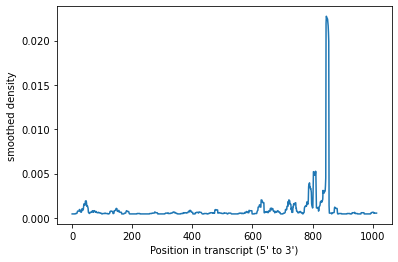

In [131]:
%matplotlib inline
plt.plot(pbar)
plt.ylabel('smoothed density')
plt.xlabel("Position in transcript (5' to 3')")

## Deconvolution 
Ok, lets just try to create A. So I have my list of lambda... have you even considered that perhaps the fact that it is lambda bar and not lambda prime is not a mistake? 

nvm, so I have a list of codons, and if I read through those codons in batches of ten along the codon sequence I will get 10* lambda prime. So, for each lambda prime, I need to know...
ok wait. The thing I do not know is the thing in the center which is what I am deconvolving for. So I have my list of lambdas b just like I used to do it, and then I have a matrix that, for each set of 10 codons along the entire sequence, says wether or not the codon appears in that set of 10. 

#### Questions:
If a certain codon shows up more than once in a set of 10 codons, then should we count that codon twice? Like, are there any 2s in this matrix? Some As have more 

Bigger questions, does the order these are in matter? I guess they do because it will effect the order that B is in, but still it feels a bit arbitrary... maybe it is a bit arbitrary.

In [132]:
A = np.zeros((len(lbar),64))

In [133]:
for row, i in zip(A, range(len(A))):
    set_of_10 = codon_seq_list[index][i:i+10]
    for j in set_of_10:
        row[j] = 1

In [134]:
b = 10*lbar

In [135]:
ls_result = lsqr(A,b)

In [136]:
Ci = ls_result[0]

In [137]:
tau = Ci.mean()
prod_r = 1/tau

In [138]:
# Computing the unscaled rates
elongation = lbar/tau
termination = sc_term # This makes no sense, it always ends up being huge... maybe it is just len(p)/M?
initiation = sc_init/tau

In [139]:
with open(save_path + mutation + '_' + my_gene +'_'+ samp_num +'.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(np.atleast_2d(elongation).T)

Text(0, 0.5, 'Ribosome counts')

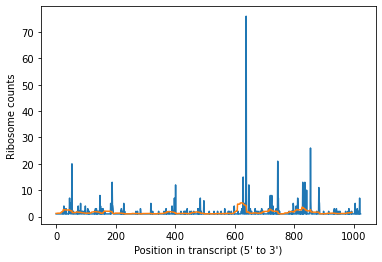

In [113]:
# 30-codon sliding window average
window = np.ones(30).astype(float)/30.0
sliding_window_avg = np.convolve(my_vector,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
#plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
#plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

In [114]:
tau

1484.2806170050733

Waaaaahhhhh. How could tau be negative? How does that ever happen? it does not look like a particularly crazy transcript or anything like that... it is just a normal bunch of count reads that produces fairly normal elongation rates and then I try to do the deconvolution and bam! complete disaster. If tau is the mean of the scaled codon specific elongation rates then literally none of these should be negative, at all.  

In [410]:
Ci

array([ -1498.49649257,  14410.66489455,   1327.14313872,      0.        ,
        -6899.616575  ,   1426.21003622,   4574.71976088,  24404.899299  ,
            0.        ,      0.        ,   5026.6251292 ,      0.        ,
            0.        ,      0.        ,      0.        ,   2928.71787885,
       -21972.7022831 ,  -9617.88495569,  -3138.61945427,      0.        ,
            0.        ,      0.        ,   7660.67827096, -33541.66725696,
         5862.13015704, -14894.80416887,      0.        ,      0.        ,
       -19561.63919857,      0.        ,   1604.26411631, -25044.68732154,
        17202.74254876,   2288.45753038,  -3749.49204379,    453.8361552 ,
       -15268.95138855,  13412.24129934,  15437.97936938,   7415.2038576 ,
       -11975.88451151,   7608.78753179,      0.        ,      0.        ,
          -68.07786671,  -6836.10701378,  -1466.89751268,  16681.33172726,
         5118.08448354,   5075.71103636,  -3587.99416625,      0.        ,
            0.        ,  